In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

In [2]:
data_path = Path(os.getcwd()).parent.joinpath("data")
assert data_path.exists()

# Read COCO Metadata

In [3]:
coco_metadata_spacy_p = data_path.joinpath("coco_metadata_spacy.df.feather")
coco_metadata_nltk_p = data_path.joinpath("coco_metadata_nltk.df.feather")
coco_metadata_polyglot_p = data_path.joinpath("coco_metadata_polyglot.df.feather")
assert coco_metadata_spacy_p.exists()
assert coco_metadata_nltk_p.exists()
assert coco_metadata_polyglot_p.exists()

In [4]:
coco_metadata_spacy = pd.read_feather(coco_metadata_spacy_p)
print(len(coco_metadata_spacy))
coco_metadata_nltk = pd.read_feather(coco_metadata_nltk_p)
print(len(coco_metadata_nltk))
coco_metadata_polyglot = pd.read_feather(coco_metadata_polyglot_p)
print(len(coco_metadata_polyglot))

cc = {'s': coco_metadata_spacy, 'n': coco_metadata_nltk, 'p': coco_metadata_polyglot}

616767
616767
616767


# Read Flickr30K Metadata

In [5]:
f30k_metadata_spacy_p = data_path.joinpath("f30k_metadata_spacy.df.feather")
f30k_metadata_nltk_p = data_path.joinpath("f30k_metadata_nltk.df.feather")
f30k_metadata_polyglot_p = data_path.joinpath("f30k_metadata_polyglot.df.feather")
assert f30k_metadata_spacy_p.exists()
assert f30k_metadata_nltk_p.exists()
assert f30k_metadata_polyglot_p.exists()

In [6]:
f30k_metadata_spacy = pd.read_feather(f30k_metadata_spacy_p)
print(len(f30k_metadata_spacy))
f30k_metadata_nltk = pd.read_feather(f30k_metadata_nltk_p)
print(len(f30k_metadata_nltk))
f30k_metadata_polyglot = pd.read_feather(f30k_metadata_polyglot_p)
print(len(f30k_metadata_polyglot))

f3 = {'s': f30k_metadata_spacy, 'n': f30k_metadata_nltk, 'p': f30k_metadata_polyglot}

158915
158915
158915


# Read WikiCaps Metadata (v1)

In [7]:
wikicaps_data_p = data_path.joinpath("v1/complete.df.feather")
assert wikicaps_data_p.exists()
wikicaps_data = pd.read_feather(wikicaps_data_p)[['wikicaps_id', 'wikimedia_file', 'caption']]
wikicaps_data.to_feather(wikicaps_data_p)
print(wikicaps_data.columns)

Index(['wikicaps_id', 'wikimedia_file', 'caption'], dtype='object')


In [8]:
wikicaps_metadata_spacy_p = data_path.joinpath("wikicaps_metadata_spacy.df.feather") 
wikicaps_metadata_nltk_p = data_path.joinpath("wikicaps_metadata_nltk.df.feather")
wikicaps_metadata_polyglot_p = data_path.joinpath("wikicaps_metadata_polyglot.df.feather")

In [9]:
wikicaps_metadata_spacy = pd.read_feather(wikicaps_metadata_spacy_p)
print(len(wikicaps_metadata_spacy))
wikicaps_metadata_nltk = pd.read_feather(wikicaps_metadata_nltk_p)
print(len(wikicaps_metadata_nltk))
wikicaps_metadata_polyglot = pd.read_feather(wikicaps_metadata_polyglot_p)
print(len(wikicaps_metadata_polyglot))

wc = {'s': wikicaps_metadata_spacy, 'n': wikicaps_metadata_nltk, 'p': wikicaps_metadata_polyglot}

187598
187598
187598


# Generate metadata for WIKICAPS WITH SPACY

In [11]:
import sys
sys.path.append('..')
from utils import generate_caption_stats

In [ ]:
pos_tags_stats = True
readability_scores = False
n_spacy_workers = 8
backend='spacy'

#wc['s'] = generate_caption_stats(wikicaps_data, pos_tags_stats, readability_scores, n_spacy_workers, backend=backend)
#wc['s'].to_feather(wikicaps_metadata_spacy_p)

# Generate metadata for WIKICAPS WITH NLTK

In [ ]:
pos_tags_stats = True
readability_scores = False
n_spacy_workers = 8
backend='nltk'

#wc['n'] = generate_caption_stats(wikicaps_data, pos_tags_stats, readability_scores, n_spacy_workers, backend=backend)
#wc['n'].to_feather(wikicaps_metadata_nltk_p)

# Generate metadata for WIKICAPS WITH POLYGLOT

In [ ]:
pos_tags_stats = True
readability_scores = False
n_spacy_workers = 8
backend='polyglot'

#wc['p'] = generate_caption_stats(wikicaps_data, pos_tags_stats, readability_scores, n_spacy_workers, backend=backend)
#wc['p'].to_feather(wikicaps_metadata_polyglot_p)

In [13]:
assert wikicaps_metadata_spacy_p.exists()
assert wikicaps_metadata_nltk_p.exists()
assert wikicaps_metadata_polyglot_p.exists()

wc['s'] = pd.read_feather(wikicaps_metadata_spacy_p)
wc['n'] = pd.read_feather(wikicaps_metadata_nltk_p)
wc['p'] = pd.read_feather(wikicaps_metadata_polyglot_p)

# Generate missing num_nouns column in polyglot generated metadata

In [16]:
from polyglot.text import Text
from tqdm import tqdm
import regex
def gen_missing_n_nouns(dataframe):
    def gen_n_noun(df, pb):
        try:
            caption = str(df['caption']).encode('utf-8')
            # https://github.com/aboSamoor/polyglot/issues/71
            # removing "bad unicode" characters to avoid runtime exceptions
            # caption = str(caption, encoding='utf-8')
            caption = regex.sub(r"\p{C}", "", caption.decode('utf-8'))

            pg = Text(caption, hint_language_code='en')
            pg.language = 'en'
            n_noun = 0
            for pos in pg.pos_tags:
                if pos[1].upper() == 'NOUN':
                    n_noun += 1

            d = {'num_nouns': n_noun}
        except Exception as e:
            print(e)
            d = {'num_nouns': 0}
        finally:
            pb.update(1)
            return d
    with tqdm(total=len(dataframe)) as pbar:
        n_nouns = dataframe.apply(gen_n_noun, axis=1, result_type='expand', args=(pbar,))
        res = pd.concat([dataframe, n_nouns], axis=1)
        res.convert_dtypes()

        return res

# a = gen_missing_n_nouns(wc['p'])
#print(a.columns)
#print(len(a.columns))

In [17]:
#wc['p'] = a

In [18]:
#wc['p'].to_feather(wikicaps_metadata_polyglot_p)

In [19]:
#b = gen_missing_n_nouns(cc['p'])
#print(b.columns)
#print(len(b.columns))

In [20]:
#cc['p'] = b
#cc['p'].to_feather(coco_metadata_polyglot_p)

# Common metadata structure for WikiCaps and COCO 


| ColumnId			| Description																| Datatype	|
|-------------------|---------------------------------------------------------------------------|-----------|
| caption			| Caption of the Image														| str		|
| num_tok			| Number of Tokens in the caption											| int		|
| num_sent			| Number of Sentences in the caption										| int		|
| min_sent_len		| Minimum number of Tokens in the Sentences of the caption					| int		|
| max_sent_len		| Maximum number of Tokens in the Sentences of the caption					| int		|
| num_ne			| Number of Named Entities in the caption									| int		|
| num_nouns			| Number of Tokens with NOUN POS Tag **										| int		|
| num_propn			| Number of Tokens with PROPN POS Tag **									| int		|
| num_conj			| Number of Tokens with CONJ POS Tag **										| int		|
| num_verb			| Number of Tokens with VERB POS Tag **										| int		|
| num_sym			| Number of Tokens with SYM POS Tag **										| int		|
| num_num			| Number of Tokens with NUM POS Tag **										| int		|
| num_adp			| Number of Tokens with ADP POS Tag **										| int		|
| num_adj			| Number of Tokens with ADJ POS Tag **										| int		|
| ratio_ne_tok		| Ratio of tokens associated with Named Entities vs all Tokens **			| int		|
| ratio_noun_tok	| Ratio of tokens tagged as NOUN vs all Tokens **							| int		|
| ratio_propn_tok	| Ratio of tokens tagged as PROPN vs all Tokens **							| int		|
| ratio_all_noun_tok| Ratio of tokens tagged as PROPN or NOUN vs all Tokens **					| int		|

# Compare
- min
- max
- median
- mean

of all columns except 'caption', 'ne_types', 'ne_texts'

In [12]:
relevant_cols = ['num_tok',
                 'num_sent',
                 'min_sent_len',
                 'max_sent_len',
                 'num_ne',
                 'num_nouns',
                 'num_propn',
                 'num_conj',
                 'num_verb',
                 'num_sym',
                 'num_num',
                 'num_adp',
                 'num_adj',
                 'ratio_ne_tok',
                 'ratio_noun_tok',
                 'ratio_propn_tok',
                 'ratio_all_noun_tok',
                 ]

min_coco_s = cc['s'][relevant_cols].min()
min_coco_n = cc['n'][relevant_cols].min()
min_coco_p = cc['p'][relevant_cols].min()

max_coco_s = cc['s'][relevant_cols].max()
max_coco_n = cc['n'][relevant_cols].max()
max_coco_p = cc['p'][relevant_cols].max()

mean_coco_s = cc['s'][relevant_cols].mean()
mean_coco_n = cc['n'][relevant_cols].mean()
mean_coco_p = cc['p'][relevant_cols].mean()

median_coco_s = cc['s'][relevant_cols].median()
median_coco_n = cc['n'][relevant_cols].median()
median_coco_p = cc['p'][relevant_cols].median()



min_f30k_s = f3['s'][relevant_cols].min()
min_f30k_n = f3['n'][relevant_cols].min()
min_f30k_p = f3['p'][relevant_cols].min()

max_f30k_s = f3['s'][relevant_cols].max()
max_f30k_n = f3['n'][relevant_cols].max()
max_f30k_p = f3['p'][relevant_cols].max()

mean_f30k_s = f3['s'][relevant_cols].mean()
mean_f30k_n = f3['n'][relevant_cols].mean()
mean_f30k_p = f3['p'][relevant_cols].mean()

median_f30k_s = f3['s'][relevant_cols].median()
median_f30k_n = f3['n'][relevant_cols].median()
median_f30k_p = f3['p'][relevant_cols].median()



min_wc_s = wc['s'][relevant_cols].min()
min_wc_n = wc['n'][relevant_cols].min()
min_wc_p = wc['p'][relevant_cols].min()

max_wc_s = wc['s'][relevant_cols].max()
max_wc_n = wc['n'][relevant_cols].max()
max_wc_p = wc['p'][relevant_cols].max()

mean_wc_s = wc['s'][relevant_cols].mean()
mean_wc_n = wc['n'][relevant_cols].mean()
mean_wc_p = wc['p'][relevant_cols].mean()

median_wc_s = wc['s'][relevant_cols].median()
median_wc_n = wc['n'][relevant_cols].median()
median_wc_p = wc['p'][relevant_cols].median()

In [13]:
compare_df = pd.DataFrame([min_coco_s, min_coco_n, min_coco_p,
                           min_f30k_s, min_f30k_n, min_f30k_p,
                           min_wc_s, min_wc_n, min_wc_p,
                           max_coco_s, max_coco_n, max_coco_p,
                           max_f30k_s, max_f30k_n, max_f30k_p,
                           max_wc_s, max_wc_n, max_wc_p,
                           mean_coco_s, mean_coco_n, mean_coco_p,
                           mean_f30k_s, mean_f30k_n, mean_f30k_p,
                           mean_wc_s, mean_wc_n, mean_wc_p,
                           median_coco_s, median_coco_n, median_coco_p,
                           median_f30k_s, median_f30k_n, median_f30k_p,
                           median_wc_s, median_wc_n, median_wc_p],
                          index=['min_coco_spacy', 'min_coco_nltk', 'min_coco_polyglot',
                                 'min_f30k_spacy', 'min_f30k_nltk', 'min_f30k_polyglot',
                                 'min_wc_spacy', 'min_wc_nltk', 'min_wc_polyglot',
                                 'max_coco_spacy', 'max_coco_nltk', 'max_coco_polyglot',
                                 'max_f30k_spacy', 'max_f30k_nltk', 'max_f30k_polyglot',
                                 'max_wc_spacy', 'max_wc_nltk', 'max_wc_polyglot',
                                 'mean_coco_spacy', 'mean_coco_nltk', 'mean_coco_polyglot',
                                 'mean_f30k_spacy', 'mean_f30k_nltk', 'mean_f30k_polyglot',
                                 'mean_wc_spacy', 'mean_wc_nltk', 'mean_wc_polyglot',
                                 'median_coco_spacy', 'median_coco_nltk', 'median_coco_polyglot',
                                 'median_f30k_spacy', 'median_f30k_nltk', 'median_f30k_polyglot',
                                 'median_wc_spacy', 'median_wc_nltk', 'median_wc_polyglot',                                 
                                ])
compare_df.head(24)

,num_tok,num_sent,min_sent_len,max_sent_len,num_ne,num_nouns,num_propn,num_conj,num_verb,num_sym,num_num,num_adp,num_adj,ratio_ne_tok,ratio_noun_tok,ratio_propn_tok,ratio_all_noun_tok
min_coco_spacy,7.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_coco_nltk,6.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_coco_polyglot,6.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_f30k_spacy,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_f30k_nltk,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_f30k_polyglot,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_wc_spacy,12.000000,2.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min_wc_nltk,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619
min_wc_polyglot,9.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max_coco_spacy,60.000000,6.000000,60.000000,60.000000,8.000000,24.000000,17.000000,0.000000,8.000000,2.000000,8.000000,14.000000,10.000000,1.000000,0.857143,1.000000,1.000000


In [14]:
compare_df.reset_index().to_feather(data_path.joinpath('coco_vs_f30k_vs_wikicaps_metadata.df.feather'))

# Plot Stuff

# Box Plots

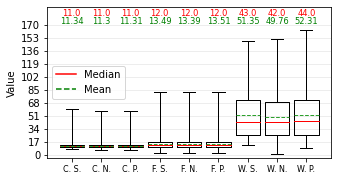

In [46]:
from matplotlib.lines import Line2D

def create_boxplot(cc, wc, f3, column, figsize=None, title=None, ylim=None, path=None):
    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(left=0.075, right=0.95, top=0.95, bottom=0.25)
    
    data = [cc['s'][column], cc['n'][column], cc['p'][column],
            f3['s'][column], f3['n'][column], f3['p'][column],
            wc['s'][column], wc['n'][column], wc['p'][column]
           ]

    num_boxes = len(data)
    labels = ['COCO Spacy', 'COCO NLTK', 'COCO polyglot',
              'Flickr30k Spacy', 'Flickr30k NLTK', 'Flickr30k polyglot',
              'WICSMMIR SpaCy', 'WICSMMIR NLTK', 'WICSMMIR polyglot']
    labels = ['C. S.', 'C. N.', 'C. P.',
              'F. S.', 'F. N.', 'F. P.',
              'W. S.', 'W. N.', 'W. P.']
    pos = .3 * np.arange(num_boxes)+1
    
    bp = ax.boxplot(data, 
                    vert=True, 
                    whis=[0, 100],
                    showfliers=False,
                    meanline=True,
                    showmeans=True,
                    widths=.25, 
                    positions=pos)
    
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='red')
    
    # Add median + mean label
    medians = [cc[x][column].median() for x in list('snp')]
    medians += [f3[x][column].median() for x in list('snp')]
    medians += [wc[x][column].median() for x in list('snp')]
    medians = [str(np.round(s, 2)) for s in medians]
    
    means = [cc[x][column].mean() for x in list('snp')]
    means += [f3[x][column].mean() for x in list('snp')]
    means += [wc[x][column].mean() for x in list('snp')]
    means = [str(np.round(s, 2)) for s in means]
    
    for tick, label in zip(range(num_boxes), ax.get_xticklabels()):
        # median label
        ax.text(pos[tick], .94, medians[tick],
                           transform=ax.get_xaxis_transform(),
                           horizontalalignment='center', size='small', color='red')
        # mean label
        ax.text(pos[tick], .89, means[tick],
                         transform=ax.get_xaxis_transform(),
                         horizontalalignment='center', size='small', color='green')

    # add legend
    fake_legend_elements = [Line2D([0], [0], color='red', label='Median'), 
                            Line2D([0], [0], ls='--', color='green', label='Mean')]
    ax.legend(handles=fake_legend_elements, loc='center left')
    
    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


    # Hide these grid behind plot objects
    ax.set_axisbelow(True)
    if title is None:
        title = f'Comparison of column {column} with WICSMMIR and COCO'
    ax.set_title(title)
    ax.set_ylabel('Value')


    #Set the axes ranges and axes labels
    ax.set_xticklabels(labels, rotation=0, fontsize=8)
    ax.set_xticks(pos)
    ax.set_xlim(pos.min() - .25, pos.max() + .25)
    
    if ylim is None:
        maxx = max([cc[x][column].max() for x in list('snp')] + [wc[x][column].max() for x in list('snp')])
        minn = min([cc[x][column].min() for x in list('snp')] + [wc[x][column].min() for x in list('snp')])
    else:
        maxx = ylim[1]
        minn = ylim[0]
    ytick = (maxx-minn) * .1
    ax.set_yticks(np.arange(0, maxx+ytick, ytick))
    ax.set_ylim(-ytick / 4, maxx+ytick * 1.4)
    
    # save plot
    if path is None:
        path = Path(os.getcwd()).joinpath(f'bp_{column}.png')
    plt.savefig(path,bbox_inches='tight')
create_boxplot(cc, wc, f3, 'num_tok', figsize = (4.5, 3), ylim=(0, 170), title="")

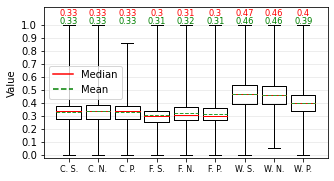

In [45]:
create_boxplot(cc, wc, f3, 'ratio_all_noun_tok', title="", figsize=(4.5,3), ylim=(0, 1.))

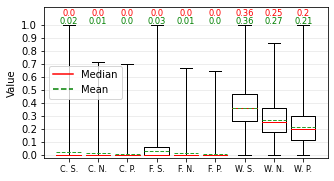

In [47]:
create_boxplot(cc, wc, f3, 'ratio_ne_tok', ylim=(0, 1.), title="", figsize=(4.5,3))

# Total Number of Tokens

In [31]:
wc_sum_tok = [wc[x]['num_tok'].sum() for x in list('snp')]
print(f"wc_sum_tok --> {wc_sum_tok}")
print(f"np.mean(wc_sum_tok) --> {np.mean(wc_sum_tok)}")

f3_sum_tok = [f3[x]['num_tok'].sum() for x in list('snp')]
print(f"f3_sum_tok --> {f3_sum_tok}")
print(f"np.mean(f3_sum_tok) --> {np.mean(f3_sum_tok)}")

cc_sum_tok = [cc[x]['num_tok'].sum() for x in list('snp')]
print(f"cc_sum_tok --> {cc_sum_tok}")
print(f"np.mean(cc_sum_tok) --> {np.mean(cc_sum_tok)}")

wc_sum_tok --> [9632327, 9335604, 9813362]
np.mean(wc_sum_tok) --> 9593764.333333334
f3_sum_tok --> [2144493, 2127903, 2146939]
np.mean(f3_sum_tok) --> 2139778.3333333335
cc_sum_tok --> [6995344, 6970538, 6975663]
np.mean(cc_sum_tok) --> 6980515.0


# Fix bug in NLTK NER Tokens 
 For some captions NLTK detected more NER Tokens than tokens in total.. which is of course not possible (WHY THE HECK IS THIS?!)
-> set this to 1.0

In [15]:
wc['p']['ratio_ne_tok'] = wc['p']['ratio_ne_tok'].where(wc['p']['ratio_ne_tok'] <= 1.0, 1.0)

In [16]:
wc['p']['ratio_ne_tok'].max()

1.0